In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from LoadData import loaddata, filter_zeroes, filter_data
import torch

simulation_names = ['Eagle', 'Mufasa', 'SC-Sam', 'Simba', 'Illustris', 'IllustrisTNG', 'UniverseMachine']
data = loaddata(simulation_names)
filtered_AH, filtered_mass_presentsfr, filtered_labels = filter_data(data) # Removes galaxies with all 0 SFHs

In [2]:
filtered_AH.shape, filtered_mass_presentsfr.shape, filtered_labels.shape # Sanity check

((63083, 139), (63083, 2), (63083,))

In [3]:
from Model import ConvAutoencoder
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR

device = torch.device("mps") # MPS on Mac

In [4]:
import torch
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset

SFH_tensor = torch.tensor(filtered_AH, dtype=torch.float32)
labels_tensor = torch.tensor(filtered_labels, dtype=torch.float32)
mass_sfr_tensor = torch.tensor(filtered_mass_presentsfr, dtype=torch.float32)

In [5]:
SFH_tensor.shape

torch.Size([63083, 139])

In [6]:
from Model import train
import random

# Set seed for reproducibility
seed = 130
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Ensures determinism

## K-fold time!!
K = 5  # Number of folds
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# Storing predictions & models
predictions_sfh = torch.zeros_like(SFH_tensor)  # SFH reconstructions
predictions_sim = torch.zeros((labels_tensor.shape[0], 7))  # Sim type predictions
predictions_sfr = torch.zeros_like(mass_sfr_tensor)  # Mass SFR predictions
latent_space = torch.zeros((SFH_tensor.shape[0], 16)) # Latent space
fold_models = []
fold_indices = []
fold_training_losses = []

for fold, (train_idx, val_idx) in enumerate(kf.split(SFH_tensor)):
    print(f"Fold {fold+1}/{K}")

    # Train and validation splits
    SFH_train, SFH_val = SFH_tensor[train_idx], SFH_tensor[val_idx]
    labels_train, labels_val = labels_tensor[train_idx], labels_tensor[val_idx]
    mass_sfr_train, mass_sfr_val = mass_sfr_tensor[train_idx], mass_sfr_tensor[val_idx]

    train_dataset = TensorDataset(SFH_train, labels_train, mass_sfr_train)
    val_dataset = TensorDataset(SFH_val, labels_val, mass_sfr_val)

    train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

    AE = ConvAutoencoder().to(device)
    optimizer = optim.Adam(AE.parameters(), lr=0.01)

    scheduler = CyclicLR(
        optimizer, 
        base_lr=0.005,  # min
        max_lr=0.02,     # max
        step_size_up=100,  
        mode='triangular2'  
    )

    losses, losses_mass_sfr, losses_sfh, losses_sim_type = train(AE, 200, device, optimizer, scheduler, train_loader, val_loader, weighted=True)
    fold_training_losses.append([losses, losses_mass_sfr, losses_sfh, losses_sim_type])
    print(f'Finished training for fold #{fold+1}')

    # Inference on the remaining fold
    AE.eval()
    with torch.no_grad():
        for i, (sfh_batch, _, _) in enumerate(val_loader): # Only need SFH for input, and batch index
            sfh_pred, sim_pred, sfr_pred = AE(sfh_batch.unsqueeze(1).to(device))
            latent_params = AE.encoder(sfh_batch.unsqueeze(1).to(device))
            
            # Save predictions in their original dataset locations (50 corresponds to te batch size)
            predictions_sfh[val_idx[i*50:(i+1)*50]] = sfh_pred.cpu().squeeze(1)
            predictions_sim[val_idx[i*50:(i+1)*50]] = sim_pred.cpu().squeeze(1)
            predictions_sfr[val_idx[i*50:(i+1)*50]] = sfr_pred.cpu().squeeze(1)
            latent_space[val_idx[i*50:(i+1)*50]] = latent_params.cpu().squeeze(1)

    # Save model and folds used for training & validation/testing
    fold_models.append(AE)
    fold_indices.append((train_idx, val_idx))

# Save predictions & models
torch.save(predictions_sfh, "predictions_sfh_w.pth")
torch.save(predictions_sim, "predictions_sim_w.pth")
torch.save(predictions_sfr, "predictions_sfr_w.pth")
torch.save(fold_models, "fold_models_w.pth")

print("K-fold finished!!!")

Fold 1/5
Epoch [0/200], Training Loss: 84.1368, Val Loss: 49.0029, SFH Loss: 34.6914, Sim Type Loss: 11.1629, Mass-SFR Loss: 3.1486
Epoch [1/200], Training Loss: 42.5296, Val Loss: 40.3984, SFH Loss: 26.6930, Sim Type Loss: 10.2479, Mass-SFR Loss: 3.4574
Epoch [2/200], Training Loss: 39.3816, Val Loss: 38.0856, SFH Loss: 25.3500, Sim Type Loss: 9.8952, Mass-SFR Loss: 2.8403
Epoch [3/200], Training Loss: 36.8758, Val Loss: 38.8609, SFH Loss: 26.6127, Sim Type Loss: 9.2952, Mass-SFR Loss: 2.9530
Epoch [4/200], Training Loss: 35.4070, Val Loss: 34.9585, SFH Loss: 23.1303, Sim Type Loss: 8.6968, Mass-SFR Loss: 3.1314
Epoch [5/200], Training Loss: 33.7116, Val Loss: 33.3642, SFH Loss: 25.1548, Sim Type Loss: 5.8059, Mass-SFR Loss: 2.4035
Epoch [6/200], Training Loss: 30.5710, Val Loss: 30.6461, SFH Loss: 22.9825, Sim Type Loss: 5.1571, Mass-SFR Loss: 2.5065
Epoch [7/200], Training Loss: 28.8675, Val Loss: 28.9756, SFH Loss: 22.9475, Sim Type Loss: 3.9562, Mass-SFR Loss: 2.0720
Epoch [8/200]

In [7]:
import pickle

with open("fold_indices.pkl", "wb") as f:
    pickle.dump(fold_indices, f)


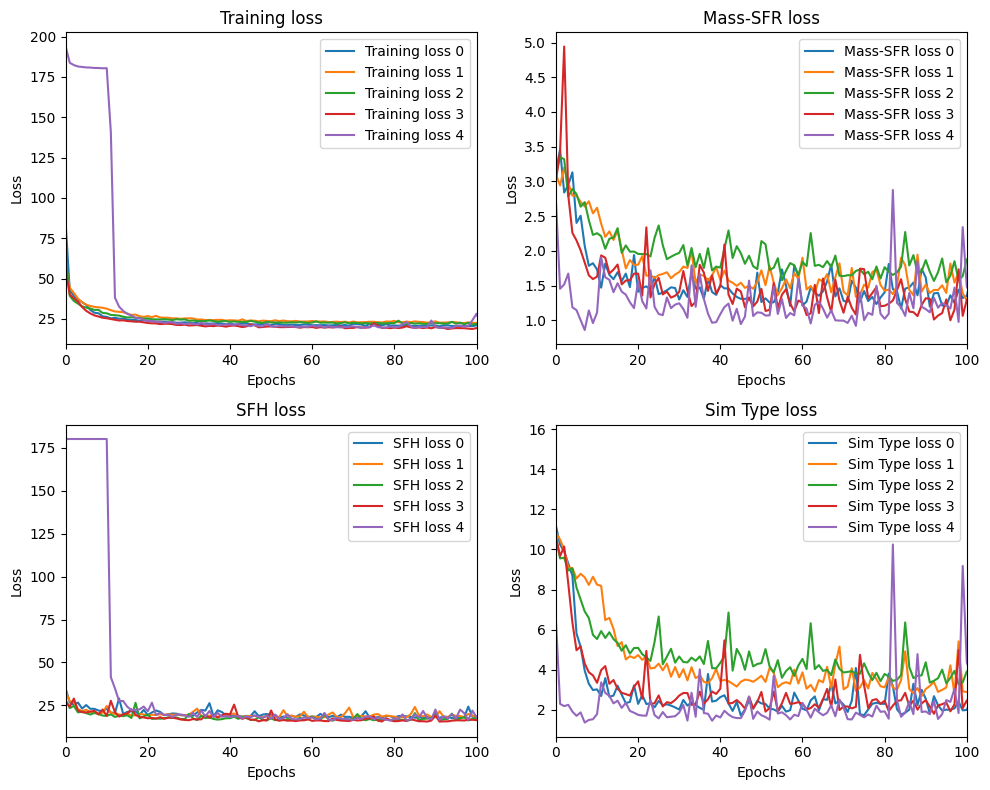

In [8]:
loss_labels = ['Training loss', 'Mass-SFR loss', 'SFH loss', 'Sim Type loss']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for loss_idx, ax in enumerate(axes.flat):
    for i in range(K):
        ax.plot(fold_training_losses[i][loss_idx], label=f'{loss_labels[loss_idx]} {i}')
    
    ax.set_xlim(0, 100)
    ax.set_title(loss_labels[loss_idx])
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()

plt.tight_layout()
plt.show()

# Some seem to converge later, but all converge eventually. Getting stuck at 22 for SFH loss means it's predicting
# the mean/making all zero predictions


In [9]:
from LoadData import un_one_hot

predictions_sim = un_one_hot(predictions_sim.detach().cpu().numpy())
correct = 0
for i in range(len(predictions_sim)):
    if np.array_equal(predictions_sim[i], filtered_labels[i]):
        correct += 1

print(f'Sim accuracy: {correct / len(predictions_sim)}')

Sim accuracy: 0.9130035033210215


In [10]:
import umap
reducer = umap.UMAP(n_components=2, n_neighbors=20)
embedding = reducer.fit_transform(latent_space)
embedding.shape

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(63083, 2)

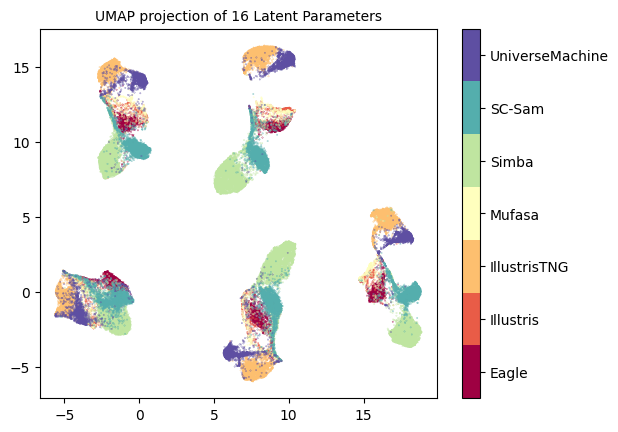

In [12]:
labels = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine']

plt.scatter(embedding[:, 0], embedding[:, 1], c=filtered_labels, cmap='Spectral', s=0.05)
plt.gca().set_aspect('equal', 'datalim')

cbar = plt.colorbar(boundaries=np.arange(8)-0.5, ticks=np.arange(7))
cbar.ax.set_yticklabels(labels)

plt.title('UMAP projection of 16 Latent Parameters', fontsize=10)
plt.show()

In [13]:
# Save latent space
torch.save(latent_space, "latent_space_w.pth")

In [14]:
predictions_sfh = torch.load("predictions_sfh_w.pth").cpu().numpy()
predictions_sim = torch.load("predictions_sim_w.pth").cpu().numpy()
predictions_sfr = torch.load("predictions_sfr_w.pth").cpu().numpy()
np.save("predictions_sfh_w.npy", predictions_sfh)
np.save("predictions_sim_w.npy", predictions_sim)
np.save("predictions_sfr_w.npy", predictions_sfr)